### Imports & Some Variables

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import matplotlib.gridspec as gridspec
import cv2
import matplotlib.image as mpimg
import os
import pickle
import pandas as pd
from sklearn.utils import shuffle
import numpy as np
from sklearn.model_selection import train_test_split
%matplotlib inline

csv = 'driving_log.csv'

### Convert CSV to Data Frame

When learning a bit more about `pandas`, I came across this use of [DataFrames](https://www.datacamp.com/community/tutorials/pandas-tutorial-dataframe-python#question1). I see it as a excel spreadsheet that can live within the realm of Python, removing the idea in my head of being tied to the csv path's location and file itself.

In [2]:
def convertCSVtoDataFrame(csv_path):
    """
    input: String - path to csv file
    output: Data Frame
    """
    df = pd.read_csv(csv_path)
    df.columns = ['center', 'left', 'right', 'steering', 'throttle', 'brake', 'speed']
    return df

### Seperation of Center, Left, Right Turns

We want to split the data into their approriate turns: center, left, and right.

In [3]:
def separateCenterLeftRightTurns(data):
    """
    input: DataFrame
    output: Arrays (3)
    """
    center_turns = []
    left_turns = []
    right_turns = []

    for idx, row in data.iterrows():
        center = row['center']
        left = row['left']
        right = row['right']
        steering = row['steering']

        if steering > 0.125:
            right_turns.append([center, left, right, steering])
        elif steering < -1 * 0.125:
            left_turns.append([center, left, right, steering])
        else:
            center_turns.append([center, left, right, steering])
    
    return center_turns, left_turns, right_turns

## Prep Training Data

### Grab Udacity Data, Convert to DataFrame, and Separate

Lets implement some of the items discussed in the lesson.

In [9]:
df_udacity = convertCSVtoDataFrame(csv)
df__udacity_features = ['center', 'left', 'right', 'steering']
# df = convertCSVtoDataFrame(csv)

center_turns, left_turns, right_turns = separateCenterLeftRightTurns(df_udacity)
print('Length of Center Turns: ', len(center_turns))
print('Length of Left Turns: ', len(left_turns))
print('Length of Right Turns: ', len(right_turns))

Length of Center Turns:  6119
Length of Left Turns:  849
Length of Right Turns:  1068


### Evaluation

Data for left and right turns are a sixth of the center turns data. Since we are going later be using some of data augmentation methods presented in class, we could duplicate the images for the left and right turn. 

### Duplicate Left and Right Images

In [24]:
def duplicateImagery(turn, increment_by):
    for i in range(len(turn)):
        for j in range(increment_by):
            turn.append([turn[i][0], turn[i][1], turn[i][2], turn[i][3]])
    return turn

df_center_turns = duplicateImagery(center_turns, 10)
df_left_turns = duplicateImagery(left_turns, 0)
df_right_turns = duplicateImagery(right_turns, 0)

u_center_turns = pd.DataFrame(df_center_turns, columns=df__udacity_features)
u_left_turns = pd.DataFrame(df_left_turns, columns=df__udacity_features)
u_right_turns = pd.DataFrame(df_right_turns, columns=df__udacity_features)

print('u_center_turns.index: ', len(u_center_turns.index))
print('u_left_turns.index: ', len(u_left_turns.index))
print('u_right_turns.index: ', len(u_right_turns.index))

u_center_turns.index:  9692496
u_left_turns.index:  2200608
u_right_turns.index:  2768256


In [25]:
# plt.hist(np.asarray(u_left_turns['steering'], dtype=np.float32))

### Shuffle

In [31]:
df_u_center_turns = shuffle(u_center_turns)
df_u_left_turns = shuffle(u_left_turns)
df_u_right_turns = shuffle(u_right_turns)

# Concat
df_concat = [df_u_center_turns, df_u_left_turns, df_u_right_turns]
train_data = pd.concat(df_concat, axis=0, join="outer", ignore_index=False)

# Shuffle One more Time
train_data = shuffle(train_data)
print('training data size: ', len(train_data.index))

training data size:  14661360


### Train Test Split

In [32]:
train_data, valid_data = train_test_split(train_data, test_size=0.2)
print('train_data size: ', len(train_data.index))
print('valid_data size: ', len(valid_data.index))

train_data size:  11729088
valid_data size:  2932272


#### Steering Angles of Training Data

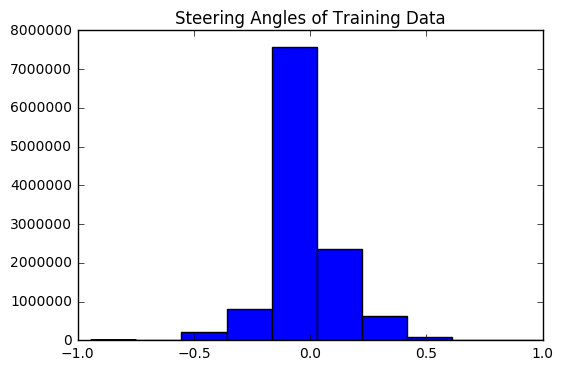

In [34]:
plt.hist(np.asarray(train_data['steering']))
plt.title('Steering Angles of Training Data')

### Data Preprocessing

#### Helpers

In [61]:
# Brightness Augmentation: We need to consider poor lighting conditions, shadows, darker lane lines
def brightness_augmentation(img):
    bright_factor = 0.2 + np.random.uniform()
    hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    hsv_img[:,:,2] = hsv_img[:,:,2] * bright_factor # change second channel
    rgb_img = cv2.cvtColor(hsv_img, cv2.COLOR_HSV2RGB)
    return rgb_img

# Flip, Flip, Flip: Trick to teach car model to drive counter-clockwise
def flip_image(img):
    return cv2.flip(img, 1)
    # image = np.fliplr(img)
    # ang = -1 * ang
    # return (image, ang)

# Crop, Crop, Crop: Focus on the road, remove excess
# Note: Keras is still an option
def crop_image(img):
    return img[img.shape[0] * 0.35 : img.shape[0] * 0.875, :, :]

# Resize: Adjust to NVIDIA's Neural Network
def resize_image(img):
    return cv2.resize(img, (220, 66), interpolation=cv2.INTER_AREA)

def convert_path_to_image(path):
    return cv2.imread(path)

def preprocess_img_given_path(path, steering):
    img = convert_path_to_image(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = brightness_augmentation(img)
    
    rndm_flip = np.random.randint(2)
    if rndm_flip == 0:
        img = flip_image(img)
    
    img = crop_image(img)
    return img, steering

def preprocess_img_valid_given_path(path, steering):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = crop_image(img)
    img = cv2.resize(img, (220, 66), interpolation=cv2.INTER_AREA)
    return img

# Original Image
# test = cv2.imread(center_turns[0][0])
# plt.title('Original Image')
# plt.imshow(test)

In [62]:
# Brightness Tweak
# test = brightness_augmentation(test)
# plt.title('Brightness Adujusted Image')
# plt.imshow(test)

In [63]:
# Brightness Tweak
# test = flip_image(test)
# plt.title('Flipped Image')
# plt.imshow(test)

In [64]:
# Crop
# test = crop_image(test)
# plt.title('Cropped Image')
# plt.imshow(test)

In [65]:
# Resize
# test = resize_image(test)
# plt.title('Resize Image')
# plt.imshow(test)

### Generators 

In [70]:
def generate_training_data(data, batch_size=32):
    """
    - Iterate through data (DataFrame)
    - Process each row (has paths to images)
    
    inputs: 
        - data: DataFrame
        - batch_size: batch size
    output: returns yield a batch of image_batch, label_batch
    """
    
    image_batch = np.zeros((batch_size * 2, 66, 220, 3)) # nvidia input params
    label_batch = np.zeros((batch_size * 2))
    
    while True:
        for i in range(batch_size):
            idx = np.random.randint(len(data))
            row = data.iloc[[idx]].reset_index()
            # x = img, y = steering
            x, y = preprocess_img_given_path(row['center'].values[0], row['steering'].values[0])
            
            x2, y2 = preprocess_img_given_path(row['center'].values[0], row['steering'].values[0])
            
            if np.random.randint(3) == 1:
                # 33% chance to overwrite center image (2) with left image + correction_factor
                x2, y2 = preprocess_img_given_path(row['left'].values[0], row['steering'] + 0.125)
            if np.random.randint(3) == 2:
                # 33% change to overwrite center image (2) give right image - correction_factor
                x2, y2 = preprocess_img_given_path(row['right'].values[0], row['steering'] - 0.125)
            
            image_batch[i] = x
            label_batch[i] = y
            
            image_batch[i + 1] = x2
            label_batch[i + 1] = y2

        yield shuffle(image_batch, label_batch)
        
def generate_validation_data(data):
    """
    data: center camera images only, because thats what we observe (dataframe)
    yields: one image, angle
    """
    while True:
        for idx in range(len(data)):
            row = data.iloc[[idx]].reset_index()
            img, angle = preprocess_img_valid_given_path(row['center'].values[0], row['steering'].values[0])
            img = img.reshape(1, img.shape[0], img.shape[1], img.shape[2])
            angle = np.array([[angle]])
            yield img, angle

### Network

Per recommendation from Udacity, I stuck with the use of Nvidia's network architecture. After some research around the activation functions, I read that Exponential Linear Units are more effective for deep models that are more than 4 layers. ELUs actually performed better within the [ImageNet challenge](https://arxiv.org/pdf/1511.07289v1.pdf) within less epochs than Rectified Linear Units.

In [71]:
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Activation, Dropout, Flatten, Dense, Lambda
from keras.layers import ELU
from keras.optimizers import Adam

# params pertain to nvidia
img_h = 66
img_w = 220
img_c = 3

def nvidia_model():
    input_shape = (img_h, img_w, img_c)

    # start model 
    model = Sequential()

    # normalization
    model.add(Lambda(lambda x: x / 127.5 - 1, input_shape=input_shape))
    
    # start neural network
    # 'he_noram' - he_normal: Gaussian initialization scaled by fan_in (He et al., 2014)
    model.add(Convolution2D(
            24, 5, 5,
            subsample=(2,2),
            border_mode="valid",
            init="he_normal",
            name="conv1"
    ))
    model.add(ELU())
    
    model.add(Convolution2D(
            36, 5, 5,
            subsample=(2,2),
            border_mode="valid",
            init="he_normal",
            name="conv2"
    ))   
    model.add(ELU())
    model.add(Dropout(0.5))
    
    model.add(Convolution2D(
            48, 5, 5,
            subsample=(2,2),
            border_mode="valid",
            init="he_normal",
            name="conv3"
    ))
    model.add(ELU())
    model.add(Dropout(0.5))
    
    model.add(Convolution2D(
            64, 3, 3,
            subsample=(1,1),
            border_mode="valid",
            init="he_normal",
            name="conv4"
    ))
    model.add(ELU())
    model.add(Dropout(0.5))

    model.add(Convolution2D(
            64, 3, 3,
            subsample=(1,1),
            border_mode="valid",
            init="he_normal",
            name="conv5"
    ))

    model.add(Flatten(name="flatten"))
    model.add(ELU())
    model.add(Dense(100, init="he_normal", name="fc1"))
    model.add(ELU())
    model.add(Dense(50, init="he_normal", name="fc2"))
    model.add(ELU())
    model.add(Dense(10, init="he_normal", name="fc3"))
    model.add(ELU())
    model.add(Dense(1, name="out", init="he_normal"))
    
    model.compile(loss='mse', optimizer='adam')
    
    return model

In [72]:
val_size = len(valid_data.index)
valid_generator = generate_validation_data(valid_data)
BATCH=16

In [74]:
model = nvidia_model()
train_size = len(train_data.index)
print('train_size:', train_size)

for i in range(3):
    train_generator = generate_training_data(train_data, BATCH)
    history = model.fit_generator(
        train_generator,
        samples_per_epoch=20480,
        nb_epoch=6,
        validation_data=valid_generator,
        nb_val_samples=val_size
    )
    print(history)
    
    model.save_weights('model-weights-F1.h5')
    model.save('model-F1.h5')

train_size: 11729088
Epoch 1/6


/Users/rudypena/anaconda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:19: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
Exception in thread Thread-7:
Traceback (most recent call last):
  File "/Users/rudypena/anaconda/envs/carnd-term1/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/Users/rudypena/anaconda/envs/carnd-term1/lib/python3.5/threading.py", line 862, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/rudypena/anaconda/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py", line 429, in data_generator_task
    generator_output = next(self._generator)
  File "<ipython-input-70-b324f43dc35f>", line 31, in generate_training_data
    image_batch[i] = x
ValueError: could not broadcast input array from shape (84,320,3) into shape (66,220,3)



ValueError: output of generator should be a tuple (x, y, sample_weight) or (x, y). Found: None